In [1]:
# Step 1 — Setup and data loading
import pandas as pd
import numpy as np

# Read the uploaded file
# Replace 'transactions.csv' with the uploaded file name
df = pd.read_csv('company_5_year_transactions.csv')

# Quick look
print("Shape:", df.shape)
df.head()

Shape: (10944, 7)


,Date,Account,Amount,Type,Vendor/Customer,Cost_Center,Description
0,2020-01-01,Insurance,94403.72,Credit,Customer-C,Operations,Transaction for Insurance with Customer-C
1,2020-01-01,Inventory Purchase,19006.12,Debit,Alpha Logistics,Operations,Transaction for Inventory Purchase with Alpha ...
2,2020-01-01,Office Supplies,115215.19,Credit,Customer-C,Sales Dept,Transaction for Office Supplies with Customer-C
3,2020-01-02,Licensing Fees,255326.54,Debit,Customer-B,Finance Dept,Transaction for Licensing Fees with Customer-B
4,2020-01-02,Maintenance,193668.69,Credit,QuickTech,HR Dept,Transaction for Maintenance with QuickTech


In [2]:
# Step 2 — Clean and prepare data

# Standardize column names (just in case CSV had weird spacing)
df.columns = df.columns.str.strip()

# Convert 'Amount' to numeric, force errors to NaN
df['Amount'] = pd.to_numeric(df['Amount'], errors='coerce')

# Handle missing values:
# Fill missing amounts with 0 (or could drop them if they’re rare)
df['Amount'] = df['Amount'].fillna(0)

# Fill missing text fields with empty strings
text_cols = ['Account', 'Type', 'Vendor/Customer', 'Cost_Center', 'Description']
df[text_cols] = df[text_cols].fillna('')

# Confirm cleaning
print(df.info())
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10944 entries, 0 to 10943
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             10944 non-null  object 
 1   Account          10944 non-null  object 
 2   Amount           10944 non-null  float64
 3   Type             10944 non-null  object 
 4   Vendor/Customer  10944 non-null  object 
 5   Cost_Center      10944 non-null  object 
 6   Description      10944 non-null  object 
dtypes: float64(1), object(6)
memory usage: 598.6+ KB
None


,Date,Account,Amount,Type,Vendor/Customer,Cost_Center,Description
0,2020-01-01,Insurance,94403.72,Credit,Customer-C,Operations,Transaction for Insurance with Customer-C
1,2020-01-01,Inventory Purchase,19006.12,Debit,Alpha Logistics,Operations,Transaction for Inventory Purchase with Alpha ...
2,2020-01-01,Office Supplies,115215.19,Credit,Customer-C,Sales Dept,Transaction for Office Supplies with Customer-C
3,2020-01-02,Licensing Fees,255326.54,Debit,Customer-B,Finance Dept,Transaction for Licensing Fees with Customer-B
4,2020-01-02,Maintenance,193668.69,Credit,QuickTech,HR Dept,Transaction for Maintenance with QuickTech


In [3]:
# Step 3 — Compute numeric anomaly (Amount) score

# Compute Z-score for Amount
df['Amount_Z'] = (df['Amount'] - df['Amount'].mean()) / df['Amount'].std()

# Convert absolute Z-score to a 0–1 suspiciousness score
# (higher z -> more unusual -> closer to 1)
df['Amount_Score'] = np.clip(abs(df['Amount_Z']) / abs(df['Amount_Z']).max(), 0, 1)

# Preview top 5 by suspiciousness
df.sort_values('Amount_Score', ascending=False).head()


,Date,Account,Amount,Type,Vendor/Customer,Cost_Center,Description,Amount_Z,Amount_Score
8563,2023-11-26,Insurance,299998.88,Credit,Bright Consulting,Operations,Transaction for Insurance with Bright Consulting,1.736994,1.000000
9194,2024-03-14,Interest Expense,299986.77,Credit,Global Corp,Finance Dept,Transaction for Interest Expense with Global Corp,1.736854,0.999919
6905,2023-02-21,Insurance,299961.00,Debit,Bright Consulting,HR Dept,Transaction for Insurance with Bright Consulting,1.736556,0.999748
2203,2021-01-06,Travel Expenses,299958.99,Debit,Metro Services,Sales Dept,Transaction for Travel Expenses with Metro Ser...,1.736532,0.999734
10450,2024-10-11,Maintenance,299935.52,Debit,Metro Services,Operations,Transaction for Maintenance with Metro Services,1.736261,0.999578


In [4]:
# Step 4 — Text embedding & anomaly scoring
# !pip install -q sentence-transformers scikit-learn

from sentence_transformers import SentenceTransformer
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler

# Load pre-trained sentence embedding model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Compute embeddings for the 'Description' column
desc_embeddings = model.encode(df['Description'].tolist(), show_progress_bar=True)

# Use Local Outlier Factor (LOF) to detect weird descriptions
lof = LocalOutlierFactor(n_neighbors=20, novelty=False)
text_outlier_scores = -lof.fit_predict(desc_embeddings)  # -1 for outlier, 1 for inlier

# Get actual LOF anomaly scores (lower = more normal, higher = more weird)
raw_lof_scores = -lof.negative_outlier_factor_

# Normalize to 0–1 range for comparison
scaler = MinMaxScaler()
df['Text_Score'] = scaler.fit_transform(raw_lof_scores.reshape(-1, 1))

# Preview most suspicious by text
df.sort_values('Text_Score', ascending=False).head()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/342 [00:00<?, ?it/s]

,Date,Account,Amount,Type,Vendor/Customer,Cost_Center,Description,Amount_Z,Amount_Score,Text_Score
8350,2023-10-24,Insurance,196504.35,Debit,Vendor-One,Operations,Transaction for Insurance with Vendor-One,0.539728,0.310725,1.000000
10932,2024-12-29,Marketing,272416.11,Debit,Customer-B,Operations,Transaction for Marketing with Customer-B,1.417905,0.816298,0.760793
1133,2020-07-07,Utilities,131269.94,Credit,Vendor-One,Operations,Transaction for Utilities with Vendor-One,-0.214929,0.123736,0.649576
8320,2023-10-18,Utilities,132541.73,Credit,Vendor-One,Operations,Transaction for Utilities with Vendor-One,-0.200217,0.115266,0.649576
1128,2020-07-06,Utilities,298810.45,Debit,Vendor-One,Finance Dept,Transaction for Utilities with Vendor-One,1.723245,0.992085,0.649576


In [5]:
# Step 5 — Combine numeric and text anomaly scores

# Define weights (you can tweak later)
w_amount = 0.6   # amount importance
w_text   = 0.4   # description importance

# Compute final suspicion index
df['Suspicion_Index'] = (w_amount * df['Amount_Score']) + (w_text * df['Text_Score'])

# Sort transactions by total suspiciousness
suspicious_txns = df.sort_values('Suspicion_Index', ascending=False)

# Show top 10 suspicious transactions
suspicious_txns.head(10)



,Date,Account,Amount,Type,Vendor/Customer,Cost_Center,Description,Amount_Z,Amount_Score,Text_Score,Suspicion_Index
1128,2020-07-06,Utilities,298810.45,Debit,Vendor-One,Finance Dept,Transaction for Utilities with Vendor-One,1.723245,0.992085,0.649576,0.855082
8339,2023-10-22,Salaries,291600.80,Credit,Global Corp,Sales Dept,Transaction for Salaries with Global Corp,1.639841,0.944069,0.615571,0.812670
10932,2024-12-29,Marketing,272416.11,Debit,Customer-B,Operations,Transaction for Marketing with Customer-B,1.417905,0.816298,0.760793,0.794096
10937,2024-12-30,Insurance,2300.58,Credit,Customer-C,Sales Dept,Transaction for Insurance with Customer-C,-1.706898,0.982673,0.418043,0.756821
3202,2021-06-20,Office Supplies,298769.78,Credit,Bright Consulting,IT Dept,Transaction for Office Supplies with Bright Co...,1.722775,0.991814,0.388937,0.750663
7750,2023-07-15,Rent,13128.93,Debit,ABC Traders,Finance Dept,Transaction for Rent with ABC Traders,-1.581631,0.910556,0.505952,0.748715
4180,2021-11-28,Inventory Purchase,292414.19,Debit,Metro Services,Operations,Transaction for Inventory Purchase with Metro ...,1.649251,0.949486,0.439506,0.745494
1080,2020-06-28,Inventory Purchase,14404.72,Credit,Metro Services,HR Dept,Transaction for Inventory Purchase with Metro ...,-1.566872,0.902060,0.439506,0.717038
8274,2023-10-12,Maintenance,3297.61,Credit,Global Corp,Finance Dept,Transaction for Maintenance with Global Corp,-1.695363,0.976033,0.285410,0.699784
10904,2024-12-24,Utilities,294451.62,Credit,Customer-A,Operations,Transaction for Utilities with Customer-A,1.672821,0.963055,0.282767,0.690940


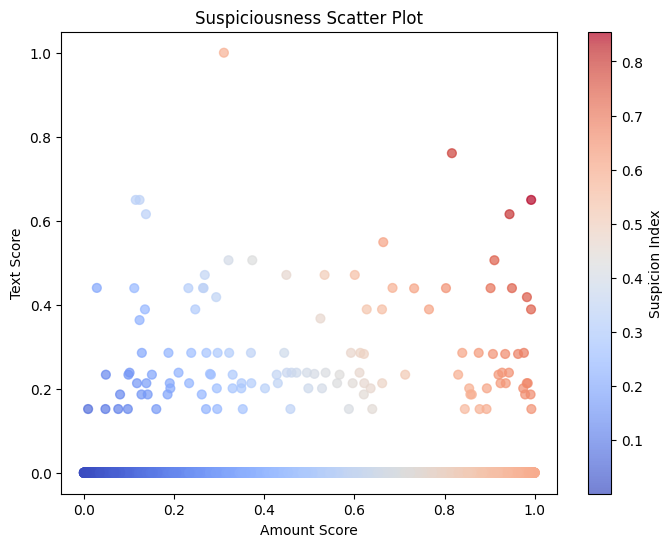

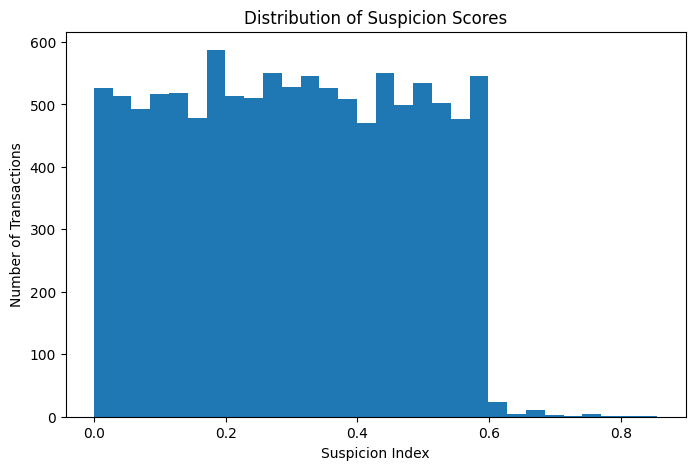

In [6]:
# Step 6 — Visualization of suspicious transactions
import matplotlib.pyplot as plt

# Scatter plot: Amount_Score vs Text_Score
plt.figure(figsize=(8,6))
plt.scatter(df['Amount_Score'], df['Text_Score'],
            c=df['Suspicion_Index'], cmap='coolwarm', s=40, alpha=0.7)
plt.colorbar(label='Suspicion Index')
plt.xlabel('Amount Score')
plt.ylabel('Text Score')
plt.title('Suspiciousness Scatter Plot')
plt.show()

# Histogram of overall suspicion
plt.figure(figsize=(8,5))
plt.hist(df['Suspicion_Index'], bins=30)
plt.xlabel('Suspicion Index')
plt.ylabel('Number of Transactions')
plt.title('Distribution of Suspicion Scores')
plt.show()


Total Income: ₹140,000.00
Total Expenses: ₹1,605,300.00
Remaining Balance: ₹-1,465,300.00
------------------------------------------------------------

Category-wise Spending:
Account
Salaries              850000.0
Marketing             500000.0
Consulting            215000.0
Training               30000.0
Inventory Purchase      6000.0
Office Supplies         4300.0
Name: Amount, dtype: float64


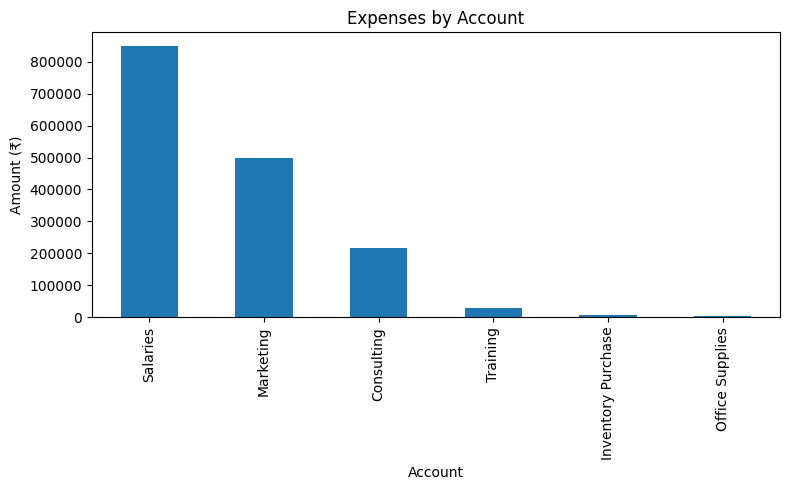

In [11]:

df = pd.read_csv('test_transaction.csv')

# Step — Financial Summary & Category Breakdown

# Ensure Amount is numeric
df['Amount'] = pd.to_numeric(df['Amount'], errors='coerce').fillna(0)

# Compute totals
total_income = df.loc[df['Type'].str.lower() == 'credit', 'Amount'].sum()
total_expenses = df.loc[df['Type'].str.lower() == 'debit', 'Amount'].sum()
remaining_balance = total_income - total_expenses

print(f"Total Income: ₹{total_income:,.2f}")
print(f"Total Expenses: ₹{total_expenses:,.2f}")
print(f"Remaining Balance: ₹{remaining_balance:,.2f}")
print("-" * 60)

# Group expenses by Account (you can switch 'Account' → 'Cost_Center' if preferred)
category_summary = (
    df[df['Type'].str.lower() == 'debit']
    .groupby('Account')['Amount']
    .sum()
    .sort_values(ascending=False)
)

print("\nCategory-wise Spending:")
print(category_summary)

# (Optional) visualize spending
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
category_summary.plot(kind='bar')
plt.title("Expenses by Account")
plt.ylabel("Amount (₹)")
plt.xlabel("Account")
plt.tight_layout()
plt.show()


In [14]:
# --- Rebuild suspicion scores (if not already present) ---

import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import LocalOutlierFactor
from sentence_transformers import SentenceTransformer

# 1️⃣ Make sure Amount is numeric
df['Amount'] = pd.to_numeric(df['Amount'], errors='coerce').fillna(0)

# 2️⃣ Amount-based score (Z-score)
df['Amount_Z'] = (df['Amount'] - df['Amount'].mean()) / df['Amount'].std()
df['Amount_Score'] = np.clip(abs(df['Amount_Z']) / abs(df['Amount_Z']).max(), 0, 1)

# 3️⃣ Text-based score (LOF on embeddings)
model = SentenceTransformer('all-MiniLM-L6-v2')
desc_embeddings = model.encode(df['Description'].tolist(), show_progress_bar=True)

lof = LocalOutlierFactor(n_neighbors=20, novelty=False)
lof.fit(desc_embeddings)
raw_lof_scores = -lof.negative_outlier_factor_

scaler = MinMaxScaler()
df['Text_Score'] = scaler.fit_transform(raw_lof_scores.reshape(-1, 1))

# 4️⃣ Combine both
w_amount = 0.6
w_text = 0.4
df['Suspicion_Index'] = (w_amount * df['Amount_Score']) + (w_text * df['Text_Score'])



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_lof.py:282: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(


In [15]:
top_suspicious = df.sort_values('Suspicion_Index', ascending=False).head(10)

print("Top Suspicious Transactions:")
display(top_suspicious[['Date', 'Account', 'Amount', 'Type',
                        'Vendor/Customer', 'Cost_Center',
                        'Description', 'Suspicion_Index']])

Top Suspicious Transactions:


,Date,Account,Amount,Type,Vendor/Customer,Cost_Center,Description,Suspicion_Index
3,04-01-2021,Salaries,850000.0,Debit,XYZ Supplies,HR Dept,Salary payment,0.601233
9,10-01-2021,Consulting,95000.0,Debit,Customer-B,Finance Dept,Consulting,0.470644
7,08-01-2021,Marketing,500000.0,Debit,QuickTech,Sales Dept,Advertising expenses for new product,0.456998
1,02-01-2021,Office Supplies,2500.0,Debit,QuickTech,Sales Dept,Stationery purchase for Q1,0.366969
4,05-01-2021,Maintenance,45000.0,Credit,Customer-B,HR Dept,Monthly maintenance service,0.315015
6,07-01-2021,Training,30000.0,Debit,Alpha Logistics,HR Dept,Staff training program,0.296274
8,09-01-2021,Office Supplies,1800.0,Debit,Alpha Logistics,Sales Dept,Pens and paper,0.153431
5,06-01-2021,Inventory Purchase,6000.0,Debit,Customer-Z,Operations,Random stuff,0.150927
0,01-01-2021,Insurance,95000.0,Credit,Customer-A,Operations,Transaction for Insurance renewal with Customer-A,0.142193
2,03-01-2021,Consulting,120000.0,Debit,Alpha Logistics,Finance Dept,Consulting fee for annual audit,0.048437


🔍 Top Suspicious Transactions:



,Date,Account,Amount,Type,Vendor/Customer,Cost_Center,Description,Suspicion_Index,Risk_Level
3,04-01-2021,Salaries,850000.0,Debit,XYZ Supplies,HR Dept,Salary payment,0.601233,⚠️ MEDIUM RISK
9,10-01-2021,Consulting,95000.0,Debit,Customer-B,Finance Dept,Consulting,0.470644,✅ Normal
7,08-01-2021,Marketing,500000.0,Debit,QuickTech,Sales Dept,Advertising expenses for new product,0.456998,✅ Normal
1,02-01-2021,Office Supplies,2500.0,Debit,QuickTech,Sales Dept,Stationery purchase for Q1,0.366969,✅ Normal
4,05-01-2021,Maintenance,45000.0,Credit,Customer-B,HR Dept,Monthly maintenance service,0.315015,✅ Normal
6,07-01-2021,Training,30000.0,Debit,Alpha Logistics,HR Dept,Staff training program,0.296274,✅ Normal
8,09-01-2021,Office Supplies,1800.0,Debit,Alpha Logistics,Sales Dept,Pens and paper,0.153431,✅ Normal
5,06-01-2021,Inventory Purchase,6000.0,Debit,Customer-Z,Operations,Random stuff,0.150927,✅ Normal
0,01-01-2021,Insurance,95000.0,Credit,Customer-A,Operations,Transaction for Insurance renewal with Customer-A,0.142193,✅ Normal
2,03-01-2021,Consulting,120000.0,Debit,Alpha Logistics,Finance Dept,Consulting fee for annual audit,0.048437,✅ Normal


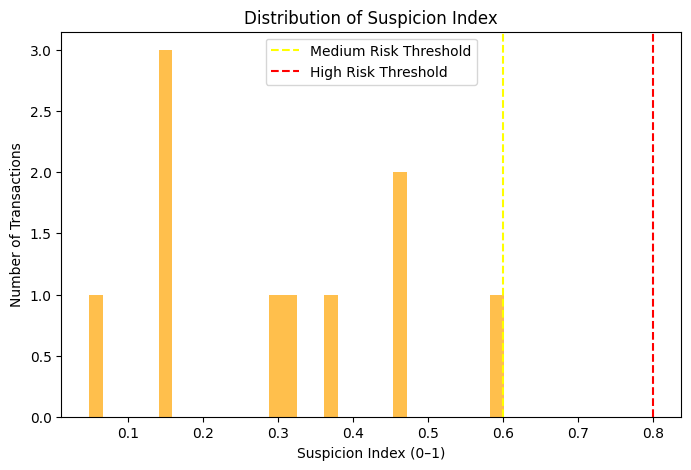

In [16]:
# Sort by suspicion level
df_sorted = df.sort_values('Suspicion_Index', ascending=False)

# Define risk level function
def risk_label(score):
    if score > 0.8:
        return "🚨 HIGH RISK"
    elif score > 0.6:
        return "⚠️  MEDIUM RISK"
    else:
        return "✅ Normal"

# Apply the label
df_sorted['Risk_Level'] = df_sorted['Suspicion_Index'].apply(risk_label)

# Display top N suspicious
top_suspicious = df_sorted.head(10)

print("🔍 Top Suspicious Transactions:\n")
display(
    top_suspicious[['Date', 'Account', 'Amount', 'Type',
                    'Vendor/Customer', 'Cost_Center',
                    'Description', 'Suspicion_Index', 'Risk_Level']]
)

# Optional: plot risk distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(df['Suspicion_Index'], bins=30, color='orange', alpha=0.7)
plt.title("Distribution of Suspicion Index")
plt.xlabel("Suspicion Index (0–1)")
plt.ylabel("Number of Transactions")
plt.axvline(0.6, color='yellow', linestyle='--', label='Medium Risk Threshold')
plt.axvline(0.8, color='red', linestyle='--', label='High Risk Threshold')
plt.legend()
plt.show()